In [69]:
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchmetrics

# Convolutional Generator

Define a convolutional generator following the DCGAN guidelines discussed in the last video.

Additionally, a custom function dc_gen_block() is available, which returns a block of a transposed convolution, batch norm, and ReLU activation. This function serves as a foundational component for constructing the convolutional generator. 

* Add the last generator block, mapping the size of the feature maps to 256.
* Add a transposed convolution with the output size of 3.
* Add the tanh activation.

In [38]:
class DCGenerator(nn.Module):
    def __init__(self, in_dim, kernel_size=4, stride=2):
        super(DCGenerator, self).__init__()
        self.in_dim = in_dim
        self.gen = nn.Sequential(
            dc_gen_block(in_dim, 1024, kernel_size, stride),
            dc_gen_block(1024, 512, kernel_size, stride),
            # Add last generator block
            dc_gen_block(512, 256, kernel_size, stride),
            # Add transposed convolution
            nn.ConvTranspose2d(256, 3, kernel_size, stride=stride),
            # Add tanh activation
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(len(x), self.in_dim, 1, 1)
        return self.gen(x)

In [3]:
def dc_gen_block(in_dim, out_dim, kernel_size, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride=stride),
        nn.BatchNorm2d(out_dim),
        nn.ReLU()
    )

# Convolutional Discriminator

With the DCGAN's generator ready, the last step before you can proceed to training it is to define the convolutional discriminator.

To build the convolutional discriminator, you will use a custom gc_disc_block() function which returns a block of a convolution followed by a batch norm and the leaky ReLU activation. You can inspect dc_disc_block()'s definition below.

* Add the first discriminator block using the custom dc_disc_block() function with 3 input feature maps and 512 output feature maps.
* Add the convolutional layer with the output size of 1.
* In the forward() method, pass the input through the sequential block you defined in __init__().

In [4]:
def dc_disc_block(in_dim, out_dim, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2),
    )

In [5]:
class DCDiscriminator(nn.Module):
    def __init__(self, kernel_size=4, stride=2):
        super(DCDiscriminator, self).__init__()
        self.disc = nn.Sequential(
          	# Add first discriminator block
            dc_disc_block(3, 512, kernel_size, stride),
            dc_disc_block(512, 1024, kernel_size, stride),
          	# Add a convolution
            nn.Conv2d(1024, 1, kernel_size, stride=stride),
        )

    def forward(self, x):
        # Pass input through sequential block
        x = self.disc(x)
        return x.view(len(x), -1)

# Generator loss

Before you can train your GAN, you need to define loss functions for both the generator and the discriminator. You will start with the former.

Recall that the generator's job is to produce such fake images that would fool the discriminator into classifying them as real. Therefore, the generator incurs a loss if the images it generated are classified by the discriminator as fake (label 0).

Define the gen_loss() function that calculates the generator loss. It takes four arguments:

1. gen, the generator model
2. disc, the discriminator model
3. num_images, the number of images in batch
4. z_dim, the size of the input random noise

* Generate random noise of shape num_images by z_dim and assign it to noise.
* Use the generator to generate a fake image from for noise and assign it to fake.
* Get discriminator's prediction for the generated fake image.
* Compute generators loss by calling criterion on discriminator's predictions and the a tensor of ones of the same shape.



In [54]:
def gen_loss_fn(gen, disc, num_images, z_dim):
    # Define random noise
    noise = torch.randn(num_images, z_dim)
    # Generate fake image
    fake = gen(noise)
    # Get discriminator's prediction on the fake image
    disc_pred = disc(fake)
    # Compute generator loss
    criterion = nn.BCEWithLogitsLoss()
    gen_loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return gen_loss


# Discriminator loss

It's time to define the loss for the discriminator. Recall that the discriminator's job is to classify images either real or fake. Therefore, the generator incurs a loss if it classifies generator's outputs as real (label 1) or the real images as fake (label 0).

Define the disc_loss() function that calculates the discriminator loss. It takes five arguments:

1. gen, the generator model
2. disc, the discriminator model
3. real, a sample of real images from the training data
4. num_images, the number of images in batch
5. z_dim, the size of the input random noise

* Use the discriminator to classify fake images and assign the predictions to disc_pred_fake.
* Compute the fake loss component by calling criterion on discriminator's predictions for fake images and the a tensor of zeros of the same shape.
* Use the discriminator to classify real images and assign the predictions to disc_pred_real.
* Compute the real loss component by calling criterion on discriminator's predictions for real images and the a tensor of ones of the same shape.



In [53]:
def disc_loss_fn(gen, disc, real, num_images, z_dim):
    criterion = nn.BCEWithLogitsLoss()
    noise = torch.randn(num_images, z_dim)
    fake = gen(noise)
    # Get discriminator's predictions for fake images
    disc_pred_fake = disc(fake)
    # Calculate the fake loss component
    fake_loss = criterion(disc_pred_fake, torch.zeros_like(disc_pred_fake))
    # Get discriminator's predictions for real images
    disc_pred_real = disc(real)
    # Calculate the real loss component
    real_loss = criterion(disc_pred_real, torch.ones_like(disc_pred_real))
    disc_loss = (real_loss + fake_loss) / 2
    return disc_loss

# Training loop

Finally, all the hard work you put into defining the model architectures and loss functions comes to fruition: it's training time! Your job is to implement and execute the GAN training loop. Note: a break statement is placed after the first batch of data to avoid a long runtime.

The two optimizers, disc_opt and gen_opt, have been initialized as Adam() optimizers. The functions to compute the losses that you defined earlier, gen_loss() and disc_loss(), are available to you.


disc_loss()'s arguments are: gen, disc, real, cur_batch_size, z_dim.

gen_loss()'s arguments are: gen, disc, cur_batch_size, z_dim.

* Calculate the discriminator loss using disc_loss() by passing it the generator, the discriminator, the sample of real images, current batch size, and the noise size of 16, in this order, and assign the result to disc_loss.
* Calculate gradients using disc_loss.
* Calculate the generator loss using gen_loss() by passing it the generator, the discriminator, current batch size, and the noise size of 16, in this order, and assign the result to gen_loss.
* Calculate gradients using gen_loss.

**Define a Dataloader**

In [23]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



Only if images folder has defined images folder classes inside it

In [13]:
# Load the dataset from the specified directory from class images
image_dir = '/kaggle/input/pokemon-images-and-types/images'
dataset = datasets.ImageFolder(root=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

FileNotFoundError: Couldn't find any class folder in /kaggle/input/pokemon-images-and-types/images.

In [43]:
# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Load image as RGB
        if self.transform:
            image = self.transform(image)
        return image

In [44]:
# Load the dataset from the specified directory
image_dir = '/kaggle/input/pokemon-images-and-types/images'
dataset = CustomImageDataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [40]:
# Define the models
z_dim = 100
gen = DCGenerator(z_dim)
disc = DCDiscriminator()

print(gen)
print(disc)

DCGenerator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2))
    (4): Tanh()
  )
)
DCDiscriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 512, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slo

In [41]:
# Define optimizers
disc_opt = optim.Adam(disc.parameters(), lr=0.0002)
gen_opt = optim.Adam(gen.parameters(), lr=0.0002)

In [58]:
for epoch in range(10):
    for real in dataloader:
        cur_batch_size = len(real)
        
        disc_opt.zero_grad()
        # Calculate discriminator loss
        d_loss = disc_loss_fn(gen, disc, real, cur_batch_size, z_dim = 100)
        # Compute gradients
        d_loss.backward()
        disc_opt.step()
        gen_opt.zero_grad()

        # Calculate generator loss
        g_loss = gen_loss_fn(gen, disc, cur_batch_size, z_dim = 100)
        # Compute generator gradients
        g_loss.backward()
        gen_opt.step()
        
        print(f"Epoch: {epoch}")
        print(f"Generator loss: {g_loss}")
        print(f"Discriminator loss: {d_loss}")
#         break

Epoch: 0
Generator loss: 1.5255342721939087
Discriminator loss: 3.56500244140625
Epoch: 0
Generator loss: 2.613938093185425
Discriminator loss: 2.5090184211730957
Epoch: 0
Generator loss: 2.9426045417785645
Discriminator loss: 2.2819876670837402
Epoch: 0
Generator loss: 2.9251248836517334
Discriminator loss: 2.3128437995910645
Epoch: 0
Generator loss: 3.0031280517578125
Discriminator loss: 2.144538164138794
Epoch: 0
Generator loss: 4.254244804382324
Discriminator loss: 1.4721238613128662
Epoch: 0
Generator loss: 5.559480667114258
Discriminator loss: 0.7883276343345642
Epoch: 0
Generator loss: 5.002510070800781
Discriminator loss: 0.7329217791557312
Epoch: 0
Generator loss: 4.100327014923096
Discriminator loss: 0.7563796043395996
Epoch: 0
Generator loss: 3.7292747497558594
Discriminator loss: 0.7176209688186646
Epoch: 0
Generator loss: 3.66789174079895
Discriminator loss: 0.6620742082595825
Epoch: 0
Generator loss: 3.376617908477783
Discriminator loss: 0.6523838043212891
Epoch: 0
Genera

# Evaluation

** Generating images**

Now that you have designed and trained your GAN, it's time to evaluate the quality of the images it can generate. For a start, you will perform a visual inspection to see if the generation resemble the Pokemons at all. To do this, you will create random noise as input for the generator, pass it to the model and plot the outputs.


* Create a random noise tensor of shape num_images_to_generate by 16, the input noise size you used to train the generator, and assign it to noise.
* Generate images by passing the noise to the generator and assign them to fake.
* Inside the for loop, slice fake to extract the i-th image and assign it to image_tensor.
* Permute image_tensor's dimensions from (color, height, width) to (hight, width, color) and assign the output to image_tensor_permuted.

Generated tensor shape: torch.Size([5, 3, 46, 46])


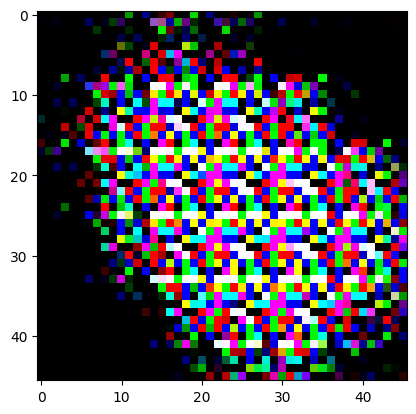

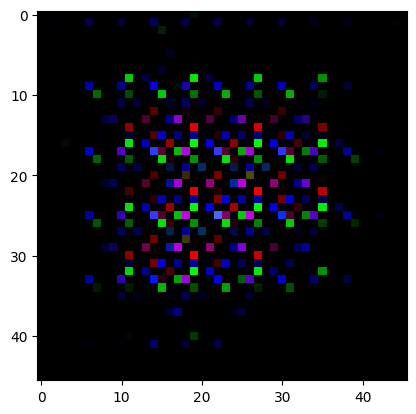

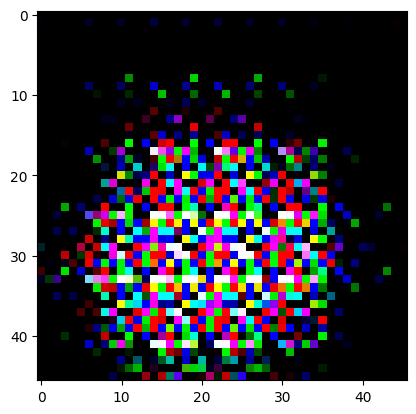

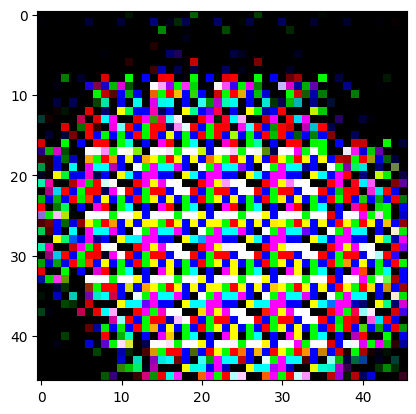

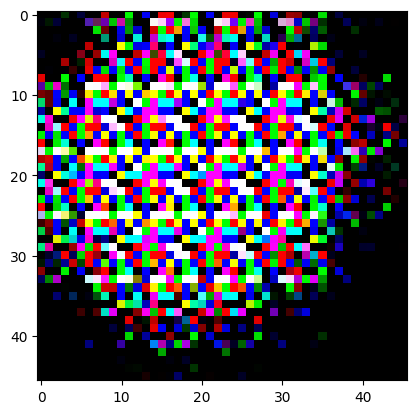

In [61]:
import matplotlib.pyplot as plt

num_images_to_generate = 5
# Create random noise tensor
noise = torch.randn(num_images_to_generate,100)

# Generate images
with torch.no_grad():
    fake = gen(noise)
print(f"Generated tensor shape: {fake.shape}")
    
for i in range(num_images_to_generate):
    # Slice fake to select i-th image
    image_tensor = fake[i, :, :, :]
    # image_tensor_permuted = (image_tensor_permuted + 1) / 2
     # Permute the image dimensions from (C, H, W) to (H, W, C)
    image_tensor_permuted = image_tensor.permute(1, 2, 0)
    plt.imshow(image_tensor_permuted)
    plt.show()

**Fréchet Inception Distance**

The visual inspection of generated images is a great start. But given they look okay, a more precise, quantitative evaluation will be helpful to understand the generator's performance. You will evaluate your GAN using the Fréchet Inception Distance, or FID.

Two tensors with fake and real images, 32 examples each, are available to you as fake and real, respectively. Use them to compute the FID!

* Import FrechetInceptionDistance from the appropriate torchmetrics module.
* Instantiate the FID metric based on the 64th Inception feature layer and assign it to fid.
* Update fid with real image tensor, multiplied by 255 and parsed to torch.uint8.
* Compute the fid metric, assigning the output to fid_score.

In [63]:
pip install torch-fidelity

Note: you may need to restart the kernel to use updated packages.


In [68]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [70]:
pip install --upgrade torchmetrics torch-fidelity


Note: you may need to restart the kernel to use updated packages.


In [74]:
# Import FrechetInceptionDistance
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64)

# Instantiate FID
# fid = FrechetInceptionDistance(feature = 64)

# Update FID with real images
fid.update((fake * 255).to(torch.uint8), real=False)
fid.update((real * 255).to(torch.uint8), real = True)

# Compute the metric
fid_score = fid.compute()
print(fid_score)

ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

In [75]:
pip show torch-fidelity
pip show torchmetrics


SyntaxError: invalid syntax (2567177437.py, line 1)